In [124]:
import pystare
import pystareplotlib
import pystareplotlib.pystareplotlib as psplot
from pystareplotlib.pystareplotlib import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.geodesic import Geodesic

import numpy
import math
from math import sqrt,sin,cos

import pyproj
import scipy.linalg
from scipy.linalg import expm, norm

import geopandas
import starepandas

from time import process_time as clock

In [102]:
from dask.distributed import Client
# client = Client(processes=False) # local workers are threads
client = Client()

In [101]:
client.shutdown()

In [3]:
import h5py

In [4]:
# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
# PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
#matplotlib notebook
%matplotlib inline

usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']

#mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
#mpl.rcParams['legend.fontsize'] = 6

mpl.rcParams['figure.dpi'] = 2 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['figure.figsize'] = [3, 3]

print('Current DPI: ',mpl.rcParamsDefault['figure.dpi'])

Current DPI:  100.0


In [5]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=-179.9
                             ,central_latitude=-89.9
                             ,satellite_height=35785831
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}

From [The IMERG multi-satellite precipitation estimates reformatted as 2-byte GeoTIFF files
for display in a Geographic Information System](https://gpm.nasa.gov/sites/default/files/2020-06/IMERG-GIS-Readme_4_22_20.pdf).

Both the HDF5 and GIS versions of IMERG contain rectangular latitude-longitude grids that have 3600 columns for longitude and 1800 rows for latitude. This grid covers the globe (90°S to 90°N and 180°W to 180°E) at 0.1° resolution.

In [6]:
def mp(l):
    return list(l)+[l[0]]

In [24]:
del grid

In [186]:
class grid:
    def __init__(self,x,y,nx_intervals,ny_intervals,name=''):
        self.x = x
        self.y = y
        self.nx_intervals = nx_intervals
        self.ny_intervals = ny_intervals
        self.Lx=x[1]-x[0]
        self.Ly=y[1]-y[0]
        self.dx=self.Lx/nx_intervals
        self.dy=self.Ly/ny_intervals
        self.name = name
    def corners(self,i,j):
        dx = self.dx
        dy = self.dy
        x0 = self.x[0]
        y0 = self.y[0]
        corners = []
        x = x0 + i*dx; y = y0 + j*dy
        corners = corners + [(x,y)]
        x = x0 + (i+1)*dx; y = y0 + j*dy
        corners = corners + [(x,y)]
        x = x0 + (i+1)*dx; y = y0 + (j+1)*dy
        corners = corners + [(x,y)]
        x = x0 + i*dx; y = y0 + (j+1)*dy
        corners = corners + [(x,y)]
        return corners
#        return [(i*dx,j*dy),((i+1)*dx,j*dy),((i+1)*dx,(j+1)*dy),((i)*dx,(j+1)*dy)]
    def corners2(self,i,j):
        return zip(*self.corners(i,j))
    def centroid(self,i,j):
        corners2 = list(self.corners2(i,j))
#        print(corners2)
#        print(list(corners2[0]))
        lon = sum(list(corners2[0]))/4.0
        lat = sum(list(corners2[1]))/4.0
        return lon,lat
    def sivs(self,i,j,level=None):
        lonlats = list(self.corners2(i,j))
        lons = lonlats[0]
        lats = lonlats[1]
        lon_,lat_=self.centroid(i,j)
#        print(lons,lats,lon_,lat_)

        center = pystare.from_latlon([lat_],[lon_],27)
        corners = pystare.from_latlon(lats,lons,27)
#        print('corners: ',corners)
        corners = pystare.adapt_resolution_to_proximity([corners[0],corners[2]])
#        print('corners: ',corners)
        corner_level = corners[0] & 31
        center[0] = (center[0] & ~31) + corner_level
#        center[0] = (center[0] & ~31) + (corner_level - 1)
    
#        print('cl: ',corner_level+1)

#        print('level: ',level,type(level))
        if level is None:
            cover = pystare.cover_from_ring(lats,lons,level=int(corner_level + 4))
        else:
            cover = pystare.cover_from_ring(lats,lons,level=int(level))
        
        return \
            [cover,lons,lats]\
            ,[center,[lon_],[lat_]]\
            ,i,j,level
    
    def sivs1(self,arg):
        return self.sivs(arg[0],arg[1],level=arg[2])
    
    def open_h5(self,filename):
        f = h5py.File(filename,'w')
        # f = h5py.File(filename,'w',libver='latest')
        info = f.create_group('info')
        cells = f.create_group('cells')
        index = f.create_group('stare_index')
        info.create_dataset('name',data = filename)
        info.create_dataset('nx_intervals',data = self.nx_intervals)
        info.create_dataset('ny_intervals',data = self.ny_intervals)
        return f,info,cells,index
    
#    def close_h5(self):
#        self.f.close()
#        return True

# This is just sivs
#    def calc_cell(self,i,j,level=None):
#        sivs,centroid = self.sivs(i,j,level)
#        return self.sivs(i,j,level)
    
    def cell_to_h5(self,c,file=None):
        f = file[0]
        info = file[1]
        cells = file[2]
        index = file[3]
        
        sivs     = c[0]
        centroid = c[1]
        i        = c[2]
        j        = c[3]
        level    = c[4]

        if j is not None:
            if i is not None:
#        for j in range(self.ny_intervals):
#            for i in range(self.nx_intervals):
#                sivs,centroid [,i,j,level] = self.sivs(i,j,level)

                
                if level is None:
                    level = (centroid[0][0] & 31) + 4
                
                l = i + self.nx_intervals*j

                try:
                    jgroup = cells.create_group(str(i)+'/'+str(j))
                except ValueError:
                    pass
                
                jgroup.create_dataset('i',data   = i)
                jgroup.create_dataset('j',data   = j)
                jgroup.create_dataset('ij',data  = l)
                
                jgroup.create_dataset('ncorners',data = len(sivs[1]))
                jgroup.create_dataset('level',   data = level)
                
                jgroup.create_dataset('lons',data  = sivs[1])
                jgroup.create_dataset('lats',data  = sivs[2])
                jgroup.create_dataset('lon_centroid',data  = centroid[1][0])
                jgroup.create_dataset('lat_centroid',data  = centroid[2][0])
                
                jgroup.create_dataset('sivs',data  = sivs[0])
                jgroup.create_dataset('sidx',data  = centroid[0][0])
                
                c_level = centroid[0][0] & 31
                
                for s in sivs[0]:
                    s_c_level = pystare.spatial_clear_to_resolution(
                        pystare.spatial_coerce_resolution(s,c_level))
                    # hidx  = hex((s_c_level & ~31)/2)
                    # bug hidx0 = hex(s_c_level)
                    hidx0 = '0x{n:016x}'.format(n=s_c_level)
                    hidx = hidx0[0:4]+'/'+hidx0[4:6]+'/'+hidx0[6:8]+'/'+hidx0[8:10]+'/'+hidx0[10:12]+'/'+hidx0[12:]
                    try:
                        s_c_group = index.create_group(hidx)
                    except ValueError:
                        s_c_group = index[hidx]
                    try:
                        s_c_ij_group = s_c_group.create_group(str(i)+'/'+str(j))
                        s_c_ij_group.create_dataset('i', data = i)
                        s_c_ij_group.create_dataset('j', data = j)
                    except ValueError:
                        pass
        
        return True
    
#    def to_h5(self,level=None):
#        for j in range(self.ny_intervals):
#            for i in range(self.nx_intervals):
#                self.cell_to_h5(i,j,level=level)
#        return True
                


In [137]:
del g10
del gr

In [138]:
g10 = grid((0,1),(0,1),10,10)
gr = g10

In [182]:
g10 = grid((-180,180),(-90,90),256,256)
gr = g10

In [188]:
gImerg = grid((-180,180),(-90,90),3600,1800)
gr = gImerg

In [173]:
(256 ** 2.0)/4096.

16.0

In [174]:
(256**2)

65536

In [183]:
# gr

def calc_cell(c):
    return gr.sivs1(c)

In [177]:
min(gr.nx_intervals*gr.ny_intervals,1024)

1024

In [187]:
! mv tmp.h5 lon256_lat256.h5

In [189]:
!rm tmp.h5

rm: tmp.h5: No such file or directory


In [168]:
2*4096

8192

In [126]:
f[0].close()

In [190]:
f = gr.open_h5('tmp.h5')

n_cells_left = gr.nx_intervals*gr.ny_intervals

block = min(n_cells_left,65536)
iblock = 0
block_results = []

ts0 = clock()
total_setup_time = 0
total_output_time  = 0
total0 = ts0

for j in range(gr.ny_intervals):
    for i in range(gr.nx_intervals):
        block_results.append(client.submit(calc_cell,(i,j,None)))
        iblock += 1
        n_cells_left -= 1
        
        if iblock > block or n_cells_left < 1 :
            t0 = clock()
            ts1 = t0
            for r in block_results:
                gr.cell_to_h5(r.result(),file=f)
            t1 = clock()
            print('setup time (s) = ',ts1-ts0,' output time (s) = ',t1-t0,' ratio = ',(t1-t0)/(ts1-ts0),' n_left: ',n_cells_left)
            total_output_time  += t1-t0
            total_setup_time   += ts1-ts0
            ts0=clock()
                
            iblock = 0
            block_results = []

total_time = clock()-total0
print('block:             ',block)
print('nx,ny,nx*ny:       ',gr.nx_intervals,gr.ny_intervals,gr.nx_intervals*gr.ny_intervals)
print('total_setup_time:  ',total_setup_time)
print('total_output_time: ',total_output_time)
print('total_time:        ',total_time)
print('ratio io/compute:  ',total_output_time/total_setup_time)
print('imerg estimate:    ',total_time*(3600*1800/( (gr.nx_intervals*gr.ny_intervals) * (3600.0 * 24.) )))

            
f[0].close()


setup time (s) =  670.113222  output time (s) =  3024.487316999999  ratio =  4.513397464346703  n_left:  6414463
setup time (s) =  690.8412690000005  output time (s) =  4608.094711999998  ratio =  6.670265542575736  n_left:  6348926
setup time (s) =  589.7544239999988  output time (s) =  4154.997463000003  ratio =  7.045301050594597  n_left:  6283389
setup time (s) =  571.6248379999997  output time (s) =  3663.8332439999976  ratio =  6.409506726158039  n_left:  6217852
setup time (s) =  583.8867979999995  output time (s) =  3979.4077840000027  ratio =  6.81537551051121  n_left:  6152315
setup time (s) =  608.8207059999986  output time (s) =  4051.165676000004  ratio =  6.654119408350105  n_left:  6086778
setup time (s) =  594.4320570000054  output time (s) =  4048.959874  ratio =  6.811476309730656  n_left:  6021241
setup time (s) =  587.2814779999972  output time (s) =  4068.654279000002  ratio =  6.927945851205649  n_left:  5955704
setup time (s) =  595.1402670000025  output time (s)

KilledWorker: ('calc_cell-b9ec526397884da0ed182101e7c9f7e5', <WorkerState 'tcp://127.0.0.1:54823', name: 1, status: closed, memory: 0, processing: 4327>)

In [155]:
total_time = 196
print('imerg estimate:    ',total_time*(3600*1800/( (gr.nx_intervals*gr.ny_intervals) * (3600.0 * 24.) )))

imerg estimate:     5.88



setup time (s) =  37.147598000000016  output time (s) =  246.88737500000025  ratio =  6.646119487994894  n_left:  12287
setup time (s) =  40.676710999999614  output time (s) =  267.23900900000035  ratio =  6.5698283472329635  n_left:  8190
setup time (s) =  38.99926400000004  output time (s) =  268.71246699999983  ratio =  6.890193286724579  n_left:  4093
setup time (s) =  40.02590000000009  output time (s) =  241.230137  ratio =  6.026851038952265  n_left:  0
block:              4096
nx,ny,nx*ny:        128 128 16384
total_setup_time:   156.84947299999976
total_output_time:  1024.0689880000004
total_time:         1181.8311910000002
ratio io/compute:   6.528992214082875
imerg estimate:     5.409993855285646

setup time (s) =  84.45048799999995  output time (s) =  518.5870029999996  ratio =  6.140722395825587  n_left:  8191
setup time (s) =  90.01747299999988  output time (s) =  519.2807619999994  ratio =  5.768666289932401  n_left:  0
block:              8192
nx,ny,nx*ny:        128 128 16384
total_setup_time:   174.46796099999983
total_output_time:  1037.867764999999
total_time:         1214.2452559999997
ratio io/compute:   5.948758494403451
imerg estimate:     5.558373669433593

setup time (s) =  634.992139  output time (s) =  4192.6424879999995  ratio =  6.602668333190184  n_left:  0
block:              65536
nx,ny,nx*ny:        256 256 65536
total_setup_time:   634.992139
total_output_time:  4192.6424879999995
total_time:         4843.300666000001
ratio io/compute:   6.602668333190184
imerg estimate:     5.5427177421569835

setup time (s) =  641.7057609999993  output time (s) =  4389.06511  ratio =  6.839684753897674  n_left:  0
block:              65536
nx,ny,nx*ny:        256 256 65536
total_setup_time:   641.7057609999993
total_output_time:  4389.06511
total_time:         5045.694835
ratio io/compute:   6.839684753897674
imerg estimate:     5.774339487075806


In [ ]:
! mv tmp.h5 

In [133]:
! du -sm tmp.h5

48	tmp.h5


In [134]:
48 * (3600*1800) / (50*50)

124416.0

In [135]:
 ( 3 * (3600*1800) / (50 ** 2) ) / ( 60.0 * 24 )

5.4

In [89]:
! open tmp.h5

In [75]:
f

(<HDF5 file "tmp.h5" (mode r+)>,
 <HDF5 group "/info" (3 members)>,
 <HDF5 group "/cells" (10 members)>,
 <HDF5 group "/stare_index" (1 members)>)

    def to_folder(self,foldername,level=None,irange=None,jrange=None):
        
        irange = range(self.nx_intervals) if irange is None else irange
        jrange = range(self.ny_intervals) if jrange is None else jrange

        for j in jrange:
            for i in irange:
                
                destfolder = os.path.join(foldername+str(i)+str(j))
                if not os.path.exists(destfolder):
                    os.mkdir(destfolder)
                    
                filename=os.path.join(destfolder,'cell.h5')
                
                f = h5py.File(filename,'w')
                info = f.create_group('info')
                info.create_dataset('name',data = filename)
                info.create_dataset('nx_intervals',data = self.nx_intervals)
                info.create_dataset('ny_intervals',data = self.ny_intervals)

                cells = f.create_group('cell')
                index = f.create_group('stare_index')           

                sivs,centroid = self.sivs(i,j,level)
                
                if level is None:
                    level = (centroid[0][0] & 31) + 4
                
                l = i + self.nx_intervals*j

                jgroup = cells.create_group(str(i)+'/'+str(j))
                
                jgroup.create_dataset('i',data   = i)
                jgroup.create_dataset('j',data   = j)
                jgroup.create_dataset('ij',data  = l)
                
                jgroup.create_dataset('ncorners',data = len(sivs[1]))
                jgroup.create_dataset('level',   data = level)
                
                jgroup.create_dataset('lons',data  = sivs[1])
                jgroup.create_dataset('lats',data  = sivs[2])
                jgroup.create_dataset('lon_centroid',data  = centroid[1][0])
                jgroup.create_dataset('lat_centroid',data  = centroid[2][0])
                
                jgroup.create_dataset('sivs',data  = sivs[0])
                jgroup.create_dataset('sidx',data  = centroid[0][0])
                
                c_level = centroid[0][0] & 31
                
                for s in sivs[0]:
                    s_c_level = pystare.spatial_clear_to_resolution(
                        pystare.spatial_coerce_resolution(s,c_level))
                    hidx0 = hex(s_c_level)
                    # hidx  = hex((s_c_level & ~31)/2)
                    hidx = hidx0[0:4]+'/'+hidx0[4:6]+'/'+hidx0[6:8]+'/'+hidx0[8:10]+'/'+hidx0[10:12]+'/'+hidx0[12:]
                    try:
                        s_c_group = index.create_group(hidx)
                    except ValueError:
                        s_c_group = index[hidx]
                    try:
                        s_c_ij_group = s_c_group.create_group(str(i)+'/'+str(j))
                        s_c_ij_group.create_dataset('i', data = i)
                        s_c_ij_group.create_dataset('j', data = j)
                    except ValueError:
                        pass
                
                f.close()
        return True

In [7]:
g10 = grid((0,1),(0,1),10,10)

In [8]:
g10.to_h5('g10.h5')

True

In [ ]:
!open g10.h5

In [ ]:
!rm g10.h5

In [ ]:
hex(4430990060083997897)

In [ ]:
list(map(hex,[4431031859937280009, 4431036257983791113, 4431038457007046665]))

In [ ]:
sivs,centroid=g10.sivs(0,6,9)
sivs,centroid,list(map(hex,sivs[0]))

In [ ]:
s1 = int(4431101784210725450)
for r in [11,10,9,8,7,6,5,4,3,2,1,0]:
    s = pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(s1,r))
    print(
#        r,'\n'
#         ,hex(int((s & ~31))),'\n'
         hex(int((s & ~31)/2))
    )

In [ ]:
sivs,centroid

In [ ]:
centroid[0][0] & 31

In [ ]:
g10.corners(0,0)

In [ ]:
g10.centroid(0,0)

In [ ]:
g20 = grid((0,1),(0,1),20,20)

In [11]:
gImerg = grid((-180,180),(-90,90),3600,1800)

In [ ]:
gImerg.corners(0,0)

In [ ]:
# i=1800; j=900
# i=50; j=50
# i=5; j = 5
i=0; j = 1

lonlats = list(gImerg.corners2(i,j))
lons = lonlats[0]
lats = lonlats[1]
lon_,lat_=gImerg.centroid(i,j)

In [28]:
gImerg = grid((-180,180),(-90,90),3600,1800)

In [ ]:
gImerg.to_h5('imerg.h5')

In [29]:
! rm imerg.h5

rm: imerg.h5: No such file or directory


In [ ]:
gr = gImerg

In [ ]:
gr = g10

In [ ]:
# i=1800; j=900
i=500; j=500
# i=50; j=50
# i=5; j = 5
# i=0; j = 1

level = 13

# sivs,centroid = gr.sivs(i,j,level)
sivs,centroid = gr.sivs(i,j)

lons = sivs[1]
lats = sivs[2]
lon_ = centroid[1][0]
lat_ = centroid[2][0]
sivs = sivs[0]

In [95]:
# f = h5py.File('imerg.h5','r')
f = h5py.File('tmp.h5','r')

cells = f.get('cells')

In [94]:
f.close()

In [98]:
ij = '1800/900/'
ij = '900/900/'
ij = '10/10/'

sivs = cells[ij+'sivs'][:]

lons = cells[ij+'lons'][:]
lats = cells[ij+'lats'][:]
lon_ = cells[ij+'lon_centroid'][()]
lat_ = cells[ij+'lat_centroid'][()]

sidx = [cells[ij+'sidx'][()]]

In [99]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=lon_
                             ,central_latitude=lat_
#                             ,satellite_height=35785831
                             ,satellite_height= 3000000
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}

In [ ]:
hex(centroid[0][0])

In [ ]:
hex(pystare.spatial_clear_to_resolution(centroid[0][0]))

In [ ]:
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=False
    ,plot_options=nearside_plot_options
#    ,plot_options=usr_plot_options
#    ,set_global=True
    ,set_global=False
    ,show_fig=False
    ,color='g'
)

if True:
    figax,sivs_cache_2,sivs_triang_2 = hello_plot(
        figax=figax
        ,spatial_index_values=centroid[0]
    #    ,spatial_index_values = sivs
        ,plot_options=nearside_plot_options
    #    ,plot_options=usr_plot_options
    #    ,set_global=True
        ,show_fig=False
        ,color='b')

if True:
    color='r'
    ls='-'
    lw=1
    figax.ax.plot(mp(lons),mp(lats)
                    ,transform=nearside_plot_options['transform']
                    ,color=color
                    ,linestyle=ls
                    ,lw=lw*0.6)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

100
200
300


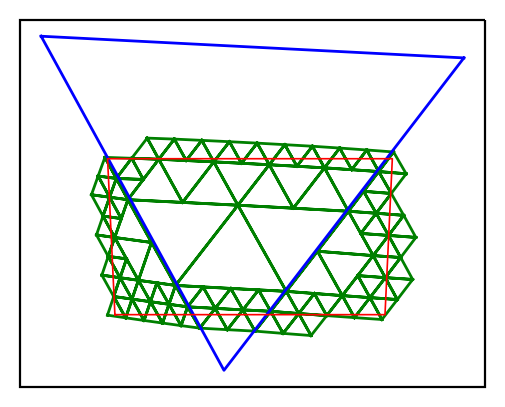

In [100]:
print('100')
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=False
    ,plot_options=nearside_plot_options
#    ,plot_options=usr_plot_options
#    ,set_global=True
    ,set_global=False
    ,show_fig=False
    ,color='g'
)

# sidx = centroid[0]

if True:
    print('200')
    figax,sivs_cache_2,sivs_triang_2 = hello_plot(
        figax=figax
        ,spatial_index_values=sidx
    #    ,spatial_index_values = sivs
        ,plot_options=nearside_plot_options
    #    ,plot_options=usr_plot_options
    #    ,set_global=True
        ,show_fig=False
        ,color='b')

if True:
    print('300')
    color='r'
    ls='-'
    lw=1
    figax.ax.plot(mp(lons),mp(lats)
                    ,transform=nearside_plot_options['transform']
                    ,color=color
                    ,linestyle=ls
                    ,lw=lw*0.6)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax